## Multinomial Choice Models and the Indepdence of Irrelevant Alternatives

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from pymc_marketing.customer_choice.mnl_logit import MNLogit
from pymc_marketing.paths import data_dir

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

Discrete choice models are a class of statistical models used to analyze and predict choices made by individuals among a finite set of alternatives. The set of alternatives ussually represent a choice between "products" broadly construed.

These models are grounded in utility maximization theory, where each option provides a certain level of utility to the decision-maker, and the option with the highest perceived utility is chosen. 

Discrete choice models are widely applied in fields like transportation, marketing, and health economics to understand behavior and inform policy or design. Common variants include the multinomial logit, nested logit, and mixed logit models, each capturing different aspects of choice behavior, such as similarity among alternatives or individual heterogeneity.
In this notebook we will demonstrate how to specify the multinomial logit model and highlight a property of this model known as the Independence of Irrelevant Alternatives. 

### The Data

We will examine a case of choices between heating systems. This data is drawn from an example in the R package `mlogit`. 

Note the data has been formatted in a "wide" fashion where each row represents a choice scenario characterised by (a) the chosen outcome `depvar`, (b) the product attributes: installation costs (`ic_x`) and operating costs (`oc_x`) and (c) fixed attributs of the agent making the choice e.g. the consumer's income and rooms. 

In [3]:
data_path = data_dir / "choice_wide_heating.csv"
df = pd.read_csv(data_path)
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


Seeing that we have 5 alternatives to choose from:

In [4]:
df["depvar"].value_counts()

depvar
gc    573
gr    129
er     84
ec     64
hp     50
Name: count, dtype: int64

The idea of discrete choice models is to determine how propensity to choose these products is driven by their observable attributes. 

### Utility Theory and Maximisation

The general idea of these models is that an individuals’ choices among observed alternatives reflect the maximization of an underlying utility function. In this framework, each alternative in a choice set is associated with a latent utility composed of observable components (e.g., cost, travel time) and unobservable factors captured as random errors. Daniel McFadden formalized this approach using random utility models, including the multinomial logit model, which assumes that the unobserved components of utility follow an extreme value distribution. His models provided a rigorous econometric foundation for analyzing choice behavior from observed decisions, enabling estimation of how changes in attributes influence choice probabilities. This work earned McFadden the Nobel Prize in Economics in 2000 and has had lasting influence in transportation, marketing, and labor economics.

To specify our multinomial logit model we therefore specify the form of the utility equations that might drive consumers to purchase particular goods amongst a choice set. Note how we distinguish each of the individual alternatives and the alternative-specific-covariates and the individual-specific-covariates by using the `|` notation. This is a variant of the standard Wilkinson stlye formula notation for specifying regression models. Under the hood we fit N regression models for each of the N goods. These regressions are used to generate a Utility score which is fed through a softmax transform to give us probabilities of each particular choice. The most probable choice should be the one with the greatest predicted utility. 

$$ \begin{split} \begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{er}   \\
u_{hp}   \\
\end{pmatrix} =  \begin{pmatrix}
gc_{ic} & gc_{oc}  \\
gr_{ic} & gr_{oc}  \\
ec_{ic} & ec_{oc}  \\
er_{ic} & er_{oc}  \\
hp_{ic} & hp_{oc}  \\
\end{pmatrix} \begin{pmatrix}
\beta_{ic}   \\
\beta_{oc}   \\
\end{pmatrix}  \end{split}
$$

$$\text{softmax}(u)_{j} = \frac{\exp(u_{j})}{\sum_{q=1}^{J}\exp(u_{q})}$$

For more details on the background theory and varieties of utility specification see the PyMC example [here](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html)





In [5]:
utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms + agehed",
    "gr ~ ic_gr + oc_gr | income + rooms + agehed",
    "ec ~ ic_ec + oc_ec | income + rooms + agehed",
    "er ~ ic_er + oc_er | income + rooms + agehed",
    "hp ~ ic_hp + oc_hp | income + rooms + agehed",
]

mnl = MNLogit(df, utility_formulas, "depvar", covariates=["ic", "oc"])
mnl

Once we have initialised our model class we can estimate the model with the sample command

In [7]:
mnl.sample( fit_kwargs={
        "target_accept": 0.97,
        "tune": 2000,
        "idata_kwargs": {"log_likelihood": True},
        "nuts_sampler": "nutpie",
        "progressbar": True,
    })

Sampling: [alphas_, betas, betas_fixed_, likelihood]
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc/sampling/mcmc.py:328: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/nutpie/compile_pymc.py:891: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', True, aligned=True))
  return inner(x, *_shared_tuple)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/nutpie/compile_pymc.py:891: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', True, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  return inner(x, *_shared_tuple)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/nutpie/compile_pymc.py:891: Num

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.10,63
,3000,0,0.09,63
,3000,0,0.10,63
,3000,0,0.09,63


Sampling: [likelihood]


/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

We can then access the fitted inference data object to inspect the posterior estimates for the model parameters of interest. 

In [7]:
az.summary(mnl.idata, var_names=["alphas", "betas", "betas_fixed"])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-clean/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-clean/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/nathanielforde/mambaforge/envs/pymc-marketing-clean/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-clean/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],1.392,0.734,0.040,2.799,0.020,0.014,1310.0,1839.0,1.0
alphas[gr],0.371,0.815,-1.208,1.832,0.021,0.013,1474.0,2095.0,1.0
alphas[ec],0.779,1.003,-1.056,2.651,0.025,0.014,1580.0,2293.0,1.0
alphas[er],2.359,0.916,0.624,4.033,0.024,0.015,1499.0,2058.0,1.0
alphas[hp],0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,3972.0,2922.0,1.0
betas[oc],-0.007,0.002,-0.010,-0.004,0.000,0.000,3114.0,2732.0,1.0
"betas_fixed[gc, income]",-0.060,0.090,-0.236,0.096,0.002,0.001,1654.0,2236.0,1.0
"betas_fixed[gc, rooms]",-0.006,0.086,-0.159,0.157,0.002,0.001,1803.0,2303.0,1.0
"betas_fixed[gc, agehed]",0.016,0.011,-0.003,0.036,0.000,0.000,1867.0,2410.0,1.0


Note here how the beta coefficients attaching to the installation and operating costs are negative implying that unit increases in cost drive a **decrease** in latent subjective utility across the consumer base. It's this kind of behaviourial insight about the attributes of each product that these models are intended to uncover. 

However, some care must be taken in the interpretation of the parameters in these models. Fundamentally discrete choice models are species of causal-inference model where we aim to not merely make inferences about relations in data but make claims about the causal effects of changes in product attributes e.g. how does the market respond to price changes? The criteria of adequacy of a discrete choice model is keyed to how plausible they are as guides to future action and action under counterfactual settings. 

### New Pricing Intervention

Consider the following intervention? How might the consumer popoulation respond to a price intervention which targets a particular market segment? We can fit the multinomial logit model as before under a pricing intervention. 

In [8]:
new_policy_df = df.copy()
new_policy_df[["ic_ec", "ic_er"]] = new_policy_df[["ic_ec", "ic_er"]] * 1.5

idata_new_policy = mnl.apply_intervention(new_choice_df=new_policy_df)

Sampling: [likelihood]


/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Then we can inspect how the market share allocated to each of the products is updated after this pricing intervention. On the one hand it makes sense to see a drop in demand for the electrical heating systems which just saw a price increase. However, we can also note a curious fact about the share allocation for the three remaining goods. Each of the goods absorbs an equal 0.08 lift in their market share. This is not a fluke. 

The observation stems from IIA property of the multinomial logit model. Under counterfactual interventions market changes lead to somewhat counter intuitive patterns of market substitution. The remaining goods on the market exhibit proportional substitution, where all remaining choices "compete" equally. This is often a quite implausible assumption about market behaviour because it fails to respect properties of market structure or preference. In our case we may wonder if consumers inclined towards electrical heating systems would all equally flock to gas systems of if their is an inherent market bias among that consumer base towards the more eco-friendly heat pump systems?

In [9]:
change_df = mnl.calculate_share_change(mnl.idata, mnl.intervention_idata)
change_df

,policy_share,new_policy_share,relative_change
product,,,
gc,0.636547,0.689529,0.083234
gr,0.143198,0.155163,0.083558
ec,0.071315,0.043382,-0.391679
er,0.093192,0.051297,-0.449557
hp,0.055749,0.060629,0.087533


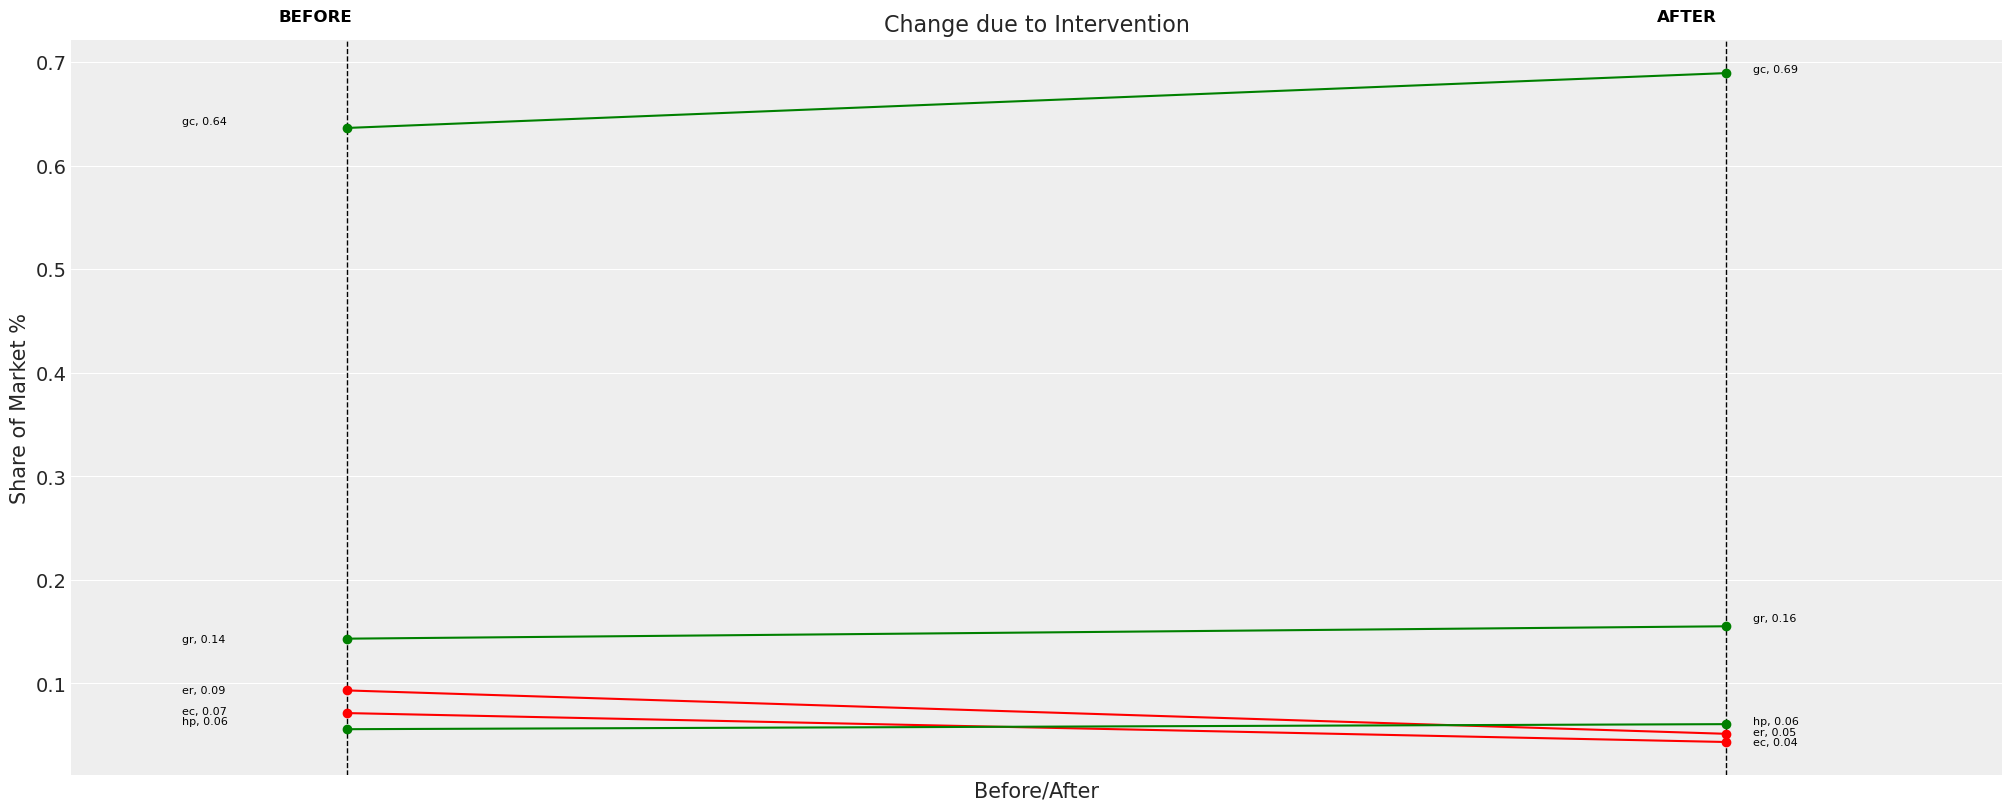

In [10]:
fig = mnl.plot_change(change_df, figsize=(20, 8))

The idea of structural preference or non-proportional substitution patterns simply cannot be accounted for with the multinomial logit model. This is occasionally called the Red-Bus, Blue Bus [paradox](https://www.youtube.com/watch?v=eciarlAhX6k) because the model property implies that even in a transport market with a 50% between a car and bus. If we introduce another bus similar in all respects to the original, then the new market is split equally between the three goods yielding a 33% share for each. This seems wrong because a new bus should only cannibalise market share from the bus consumers. 

Let's see how this pattern plays out in our example. We can remove a product as follows and re-estimate our multinomial logit. 

### Market Product Intervention


In [11]:
new_policy_df = df.copy()
new_policy_df = new_policy_df[new_policy_df["depvar"] != "hp"]

new_utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms + agehed",
    "gr ~ ic_gr + oc_gr | income + rooms + agehed",
    "ec ~ ic_ec + oc_ec | income + rooms + agehed",
    "er ~ ic_er + oc_er | income + rooms + agehed",
    #'hp ~ ic_hp + oc_hp | income + rooms + agehed'
]

idata_new_policy = mnl.apply_intervention(
    new_choice_df=new_policy_df, new_utility_equations=new_utility_formulas
)

Sampling: [alphas_, betas, betas_fixed_, likelihood]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas_, betas, betas_fixed_]
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Output()

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 100 seconds.
Sampling: [likelihood]


Output()

Here agains we see a basically proportional re-allocation where the market demand is re-allocated equally across the remaining goods. 

In [12]:
change_df = mnl.calculate_share_change(mnl.idata, mnl.intervention_idata)
change_df

,policy_share,new_policy_share,relative_change
product,,,
gc,0.636547,0.674460,0.059561
gr,0.143198,0.151770,0.059865
ec,0.071315,0.075343,0.056478
er,0.093192,0.098427,0.056174
hp,0.055749,0.000000,-1.000000


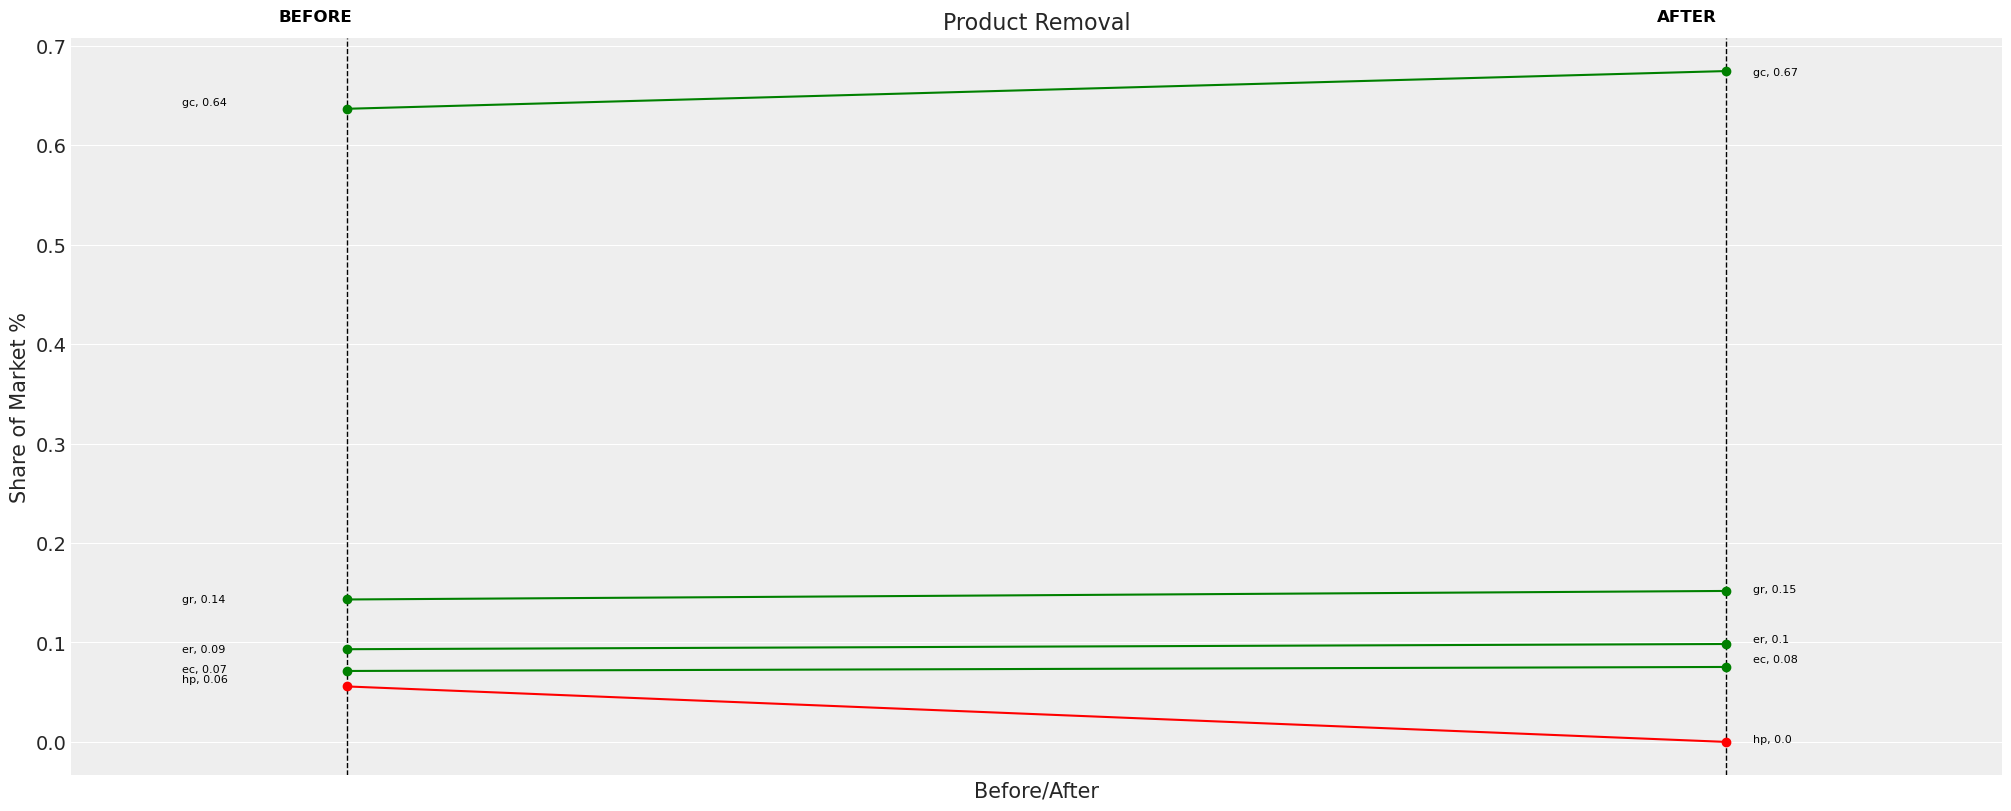

In [13]:
fig = mnl.plot_change(change_df, title="Product Removal", figsize=(20, 8))

### Counterfactual Plausibility as a Criteria of Adequacy

Kenneth Train observes that 

> "[The IIA] property can be seen either as a restriction imposed by the model or as the natural outcome of a wellspecified model that captures all sources of correlation over alternatives into representative utility, so that only white noise remains. Often the researcher is unable to capture all sources of correlation explicitly, so
that the unobserved portions of utility are correlated and IIA does not hold." - pg 76 in "Discrete Choice Methods with Simulation"

which suggests that the Multinomial Logit model can have a compelling role in markets where the structure of the preferences aren't governed by anything we haven't included in the utility equations. But given the difficulty of such a comprehensive model specification we might want to seek alternative model specifications that can support more plausible counterfactual inference about the patterns of market substitution under intervention. One such model specification is the nested logit model. 

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Dec 20 2025

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.8.0

pytensor: 2.35.1

pymc_marketing: 0.17.1
matplotlib    : 3.10.8
pandas        : 2.3.3
arviz         : 0.23.0

Watermark: 2.5.0

